# Food Classification

Firts you have download the db, with the next cell

In [0]:
!wget -nc https://www.dropbox.com/s/n5k259p1ba677pk/amoestadb.zip?dl=0
!unzip amoestadb.zip?dl=0
!unzip amoestadb.zip

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
%cd /content/drive/My Drive/deeplearning/2020.deeplearning/U3project

/content/drive/My Drive/deeplearning/2020.deeplearning/U3project


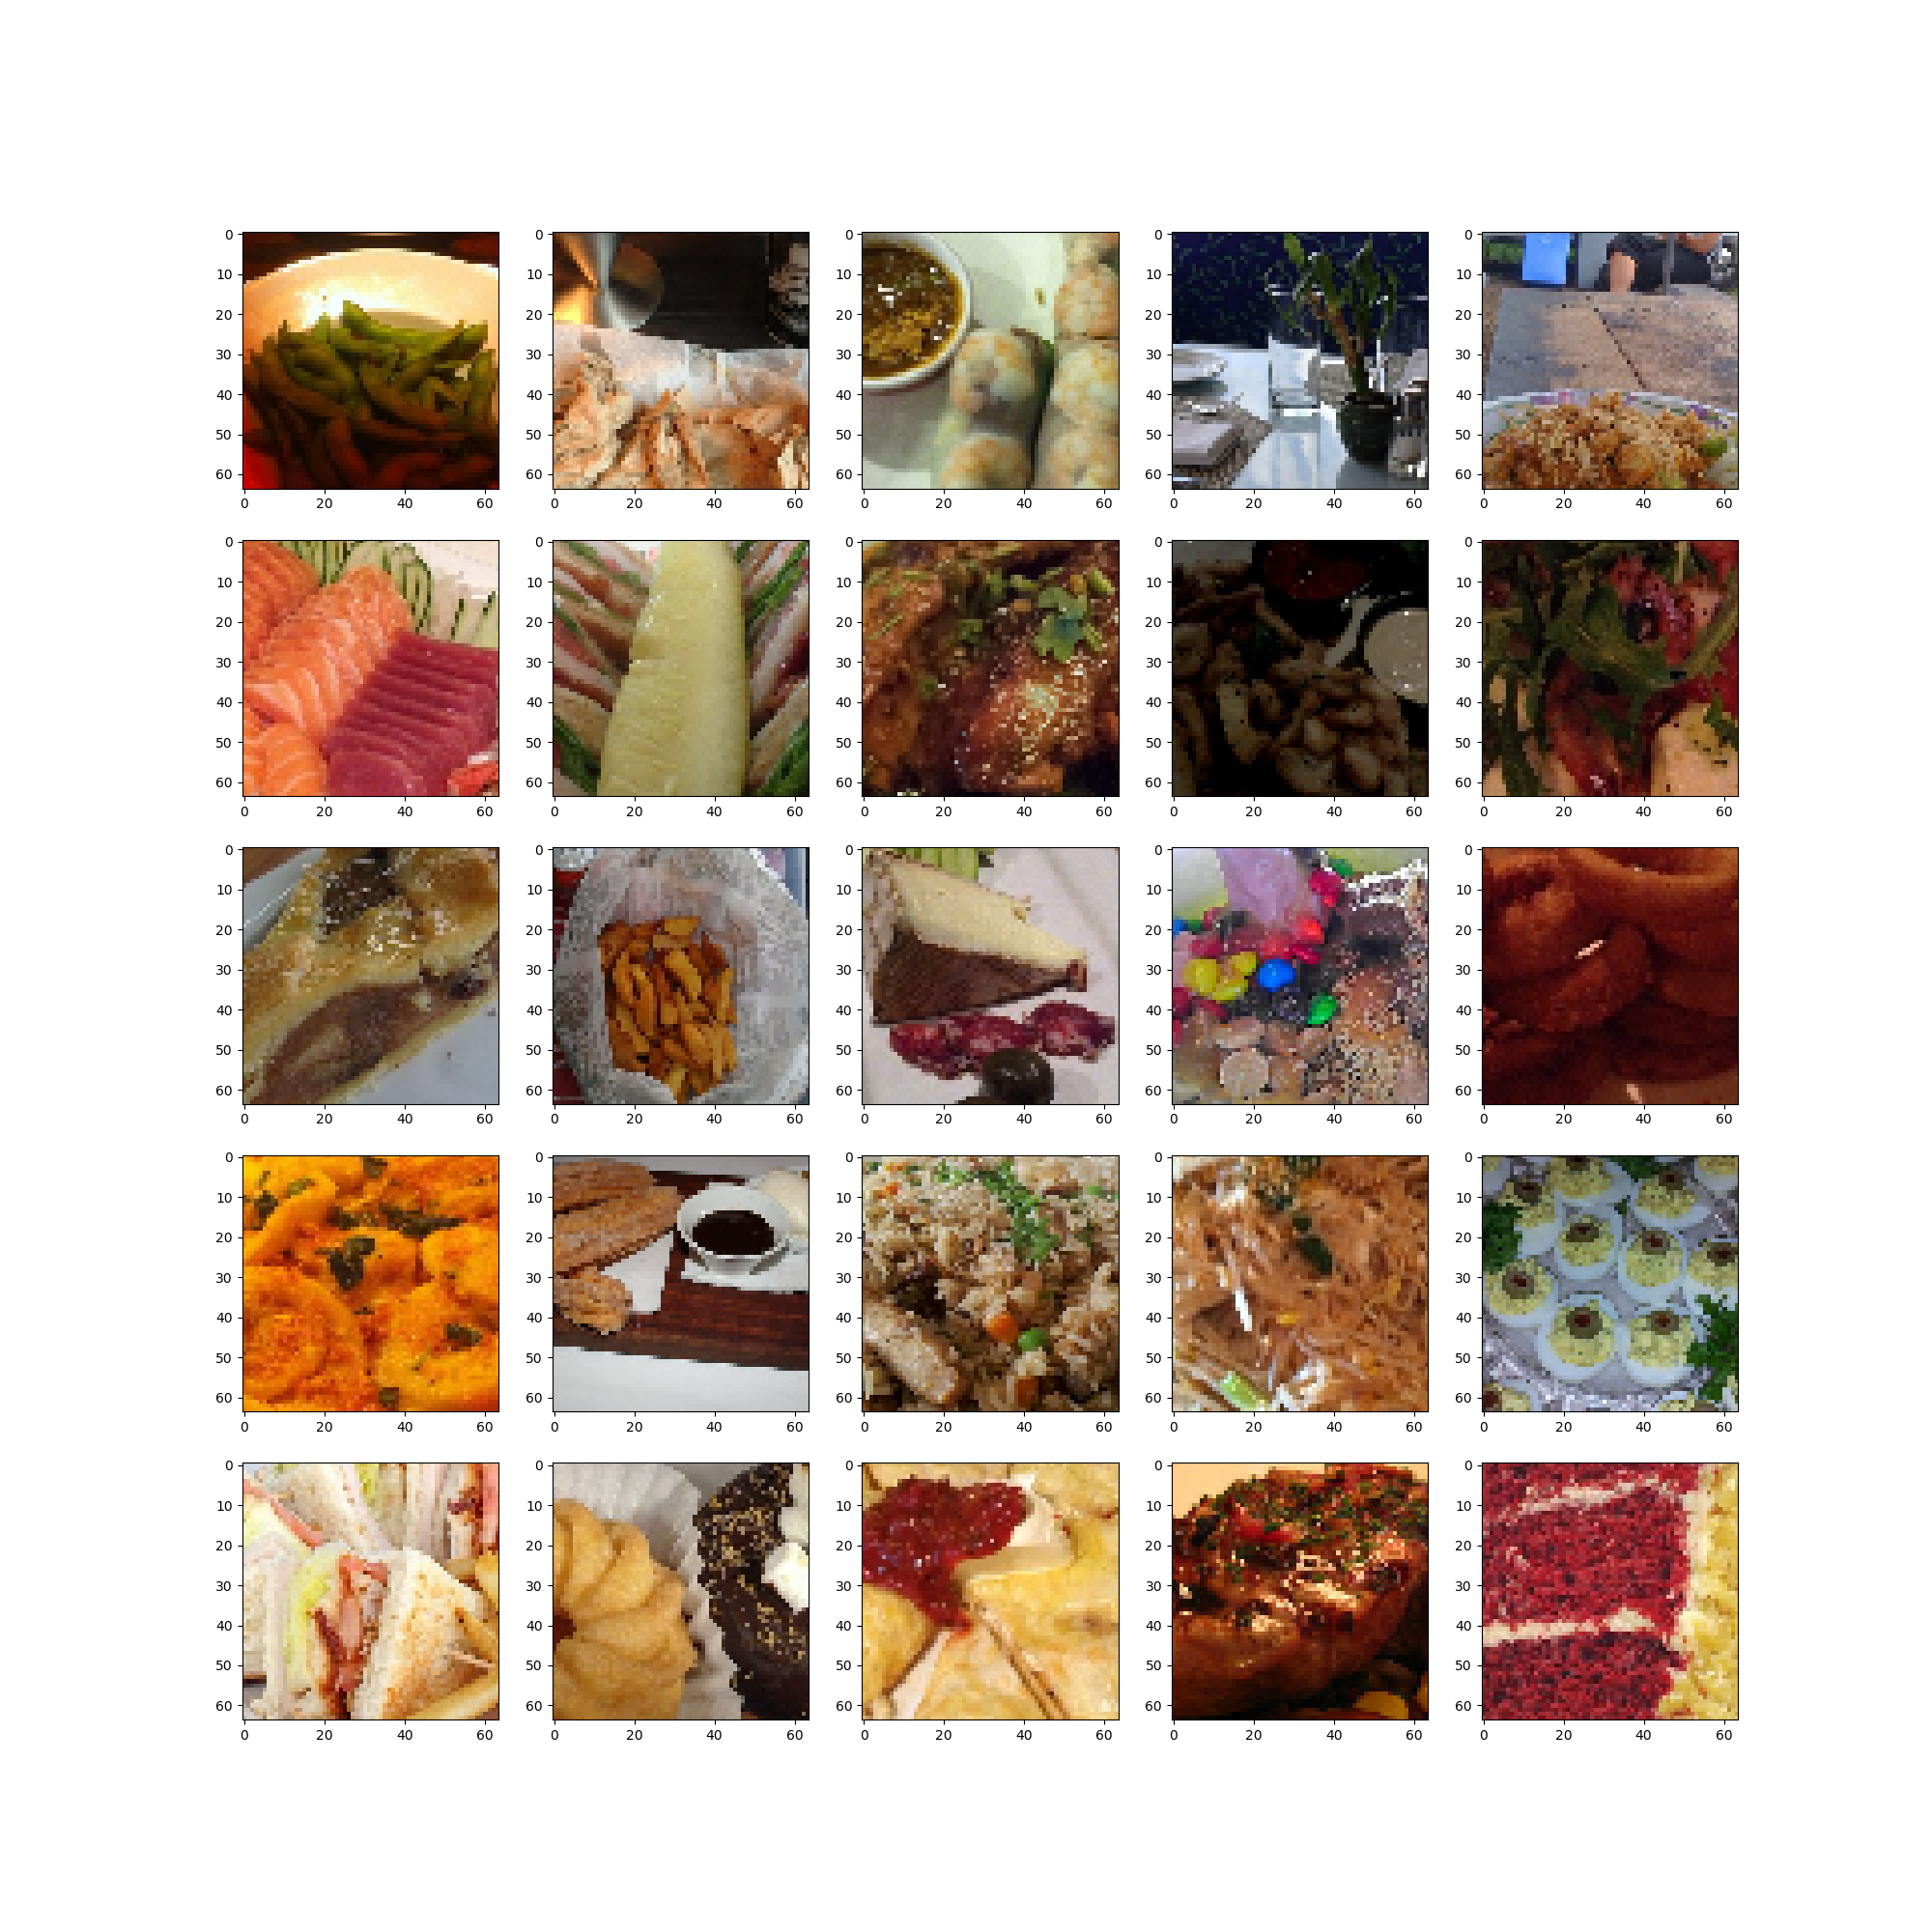

In [12]:
from IPython.display import Image
Image(filename='food.png',width="800")

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras import optimizers
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import tensorflow as tf

In [0]:
cd /home/davidrendon/Documents/proyectou3deep #

/home/davidrendon/Documents/proyectou3deep


The below are the classes to classify 

breakfast_burrito/  donuts/         guacamole/        seaweed_salad/
chicken_wings/      edamame/        hamburger/        spaghetti_bolognese/
churros/            french_fries/   red_velvet_cake/
cup_cakes/          frozen_yogurt/  sashimi/

#Attemps 

Firts i try with a network constructed by myself but i get an lower accuracy. So i decide to apply transfer learning

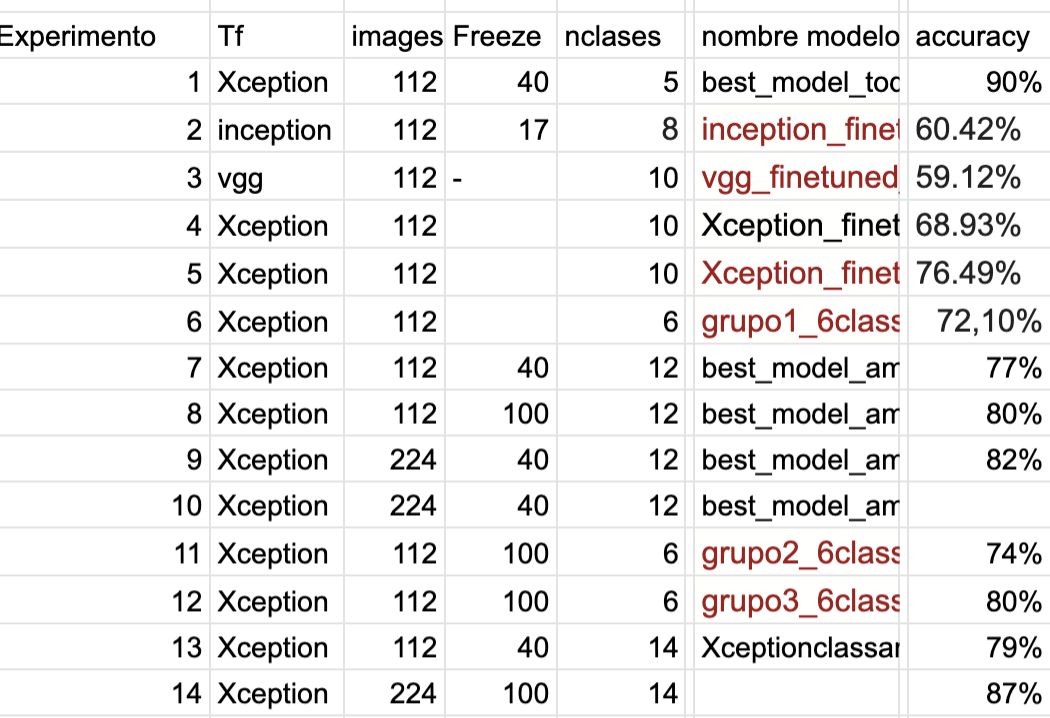

In [10]:
Image(filename='experiments.png',width="400")


as we see i start applying vgg and inception, nex i found this table 

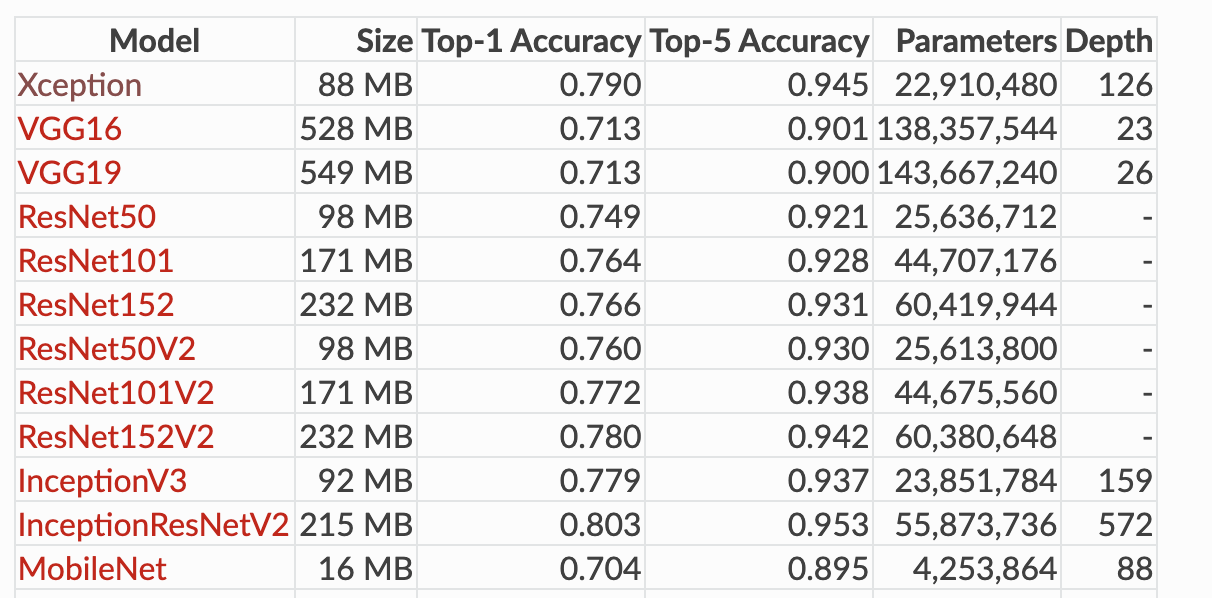

In [13]:
Image(filename='trans.png',width="400")

and i start to do experiments changing the parameters of the network (Regularization, dropout,image size...) until i found images like below 

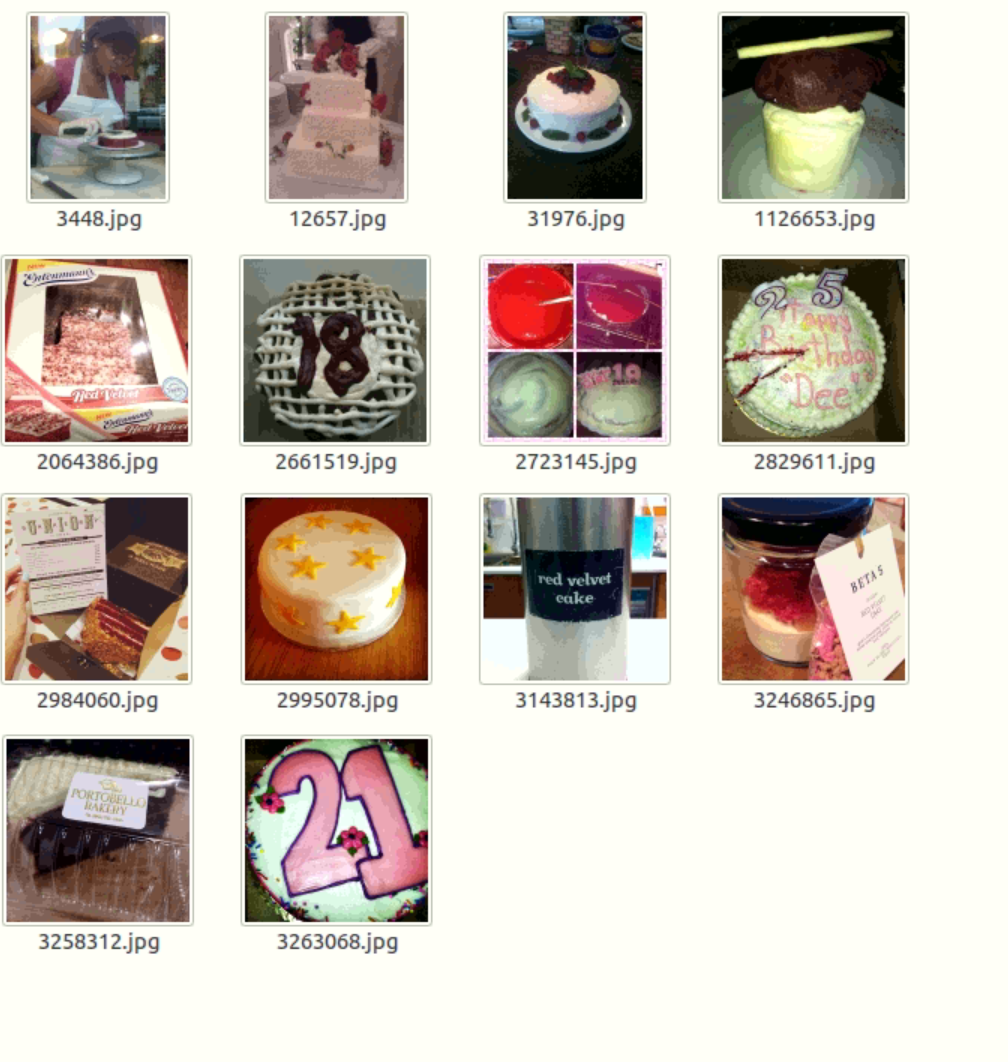

In [14]:
Image(filename='fake.png',width="1000")

So i delete the images that doesnt aport information for my model.

# parameters  to train the network

In [0]:
train_data_dir='amoestadb'


In [0]:
TEST_SPLIT = 0.25
epochs = 80
#batch_size = 16
batch_size=32
MICRO_DATA = True # very small subset (just 3 groups)
SAMPLE_TRAINING = False # make train set smaller for faster iteration
IMG_SIZE = (112, 112)
LEARNING_RATE = 0.001
seed=1

In [0]:
Image(filename='/trans.png')

In [0]:
from keras import applications
model = applications.Xception(weights='imagenet', 
                                include_top=False, input_shape = (112,112,3))

# Training with ImageDataGenerator

The data loading is implemented through the Keras ImageDataGenerator, this avoids loading the images in their entirety and only the images used by each batch in the training are loaded. for the img size i decided to train with 224 becouse the images have good resolution

In [0]:
IMG_SIZE = (224, 224)
train_datagen = ImageDataGenerator(rescale=1/255.,
    horizontal_flip=False,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',seed=seed) # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',seed=seed) # set as validation data

Found 10997 images belonging to 14 classes.
Found 2742 images belonging to 14 classes.


i decide to freeze 100 layers and include others with regularization and ad a dropout of 0.4, the model are save in best_model_amodb14classes224.hdf5

In [0]:
from keras import applications
model = applications.Xception(weights='imagenet', 
                                include_top=False, input_shape = (224,224,3))



len(model.layers)

for layer in model.layers[:100]:
    layer.trainable = False
regparameter=0.0001

x = model.output
x = Flatten()(x)
x = Dense(256, activation="relu",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=regparameter,l2=regparameter))(x)
x = Dropout(0.4)(x)
x = Dense(4096, activation="relu")(x)
predictions = Dense(14, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])
model_final.summary()







Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

/home/davidrendon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


tensorflow.python.keras.callbacks.ModelCheckpoint

In [0]:
from tensorflow import keras


chkpt = ModelCheckpoint(filepath='best_model_amodb12classes224.hdf5', save_best_only=True, save_weights_only=True)


model_final.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 20,callbacks=[chkpt])

Epoch 1/20
343/343 [==============================] - 1085s 3s/step - loss: 1.3552 - accuracy: 0.9497 - val_loss: 1.0886 - val_accuracy: 0.9004
Epoch 2/20
343/343 [==============================] - 1075s 3s/step - loss: 0.6397 - accuracy: 0.9802 - val_loss: 0.7808 - val_accuracy: 0.8638
Epoch 3/20
343/343 [==============================] - 1070s 3s/step - loss: 0.5493 - accuracy: 0.9840 - val_loss: 1.2678 - val_accuracy: 0.8889
Epoch 4/20
343/343 [==============================] - 1069s 3s/step - loss: 0.6424 - accuracy: 0.9809 - val_loss: 0.6899 - val_accuracy: 0.8638
Epoch 5/20
343/343 [==============================] - 1072s 3s/step - loss: 0.6225 - accuracy: 0.9782 - val_loss: 0.5434 - val_accuracy: 0.8967
Epoch 6/20
249/343 [====================>.........] - ETA: 4:09 - loss: 0.5864 - accuracy: 0.9847

KeyboardInterrupt: 

In [0]:

train_datagen = ImageDataGenerator(rescale=1/255.,
    horizontal_flip=False,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',seed=seed,shuffle=False) # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',seed=seed,shuffle=False) # set as validation data

Found 10997 images belonging to 14 classes.
Found 2742 images belonging to 14 classes.


In [0]:
model_final.evaluate_generator(validation_generator)

[0.7915205955505371, 0.8767322897911072]

In [0]:
prob=model_final.predict_generator(validation_generator)

In [0]:
prob.shape


(2742, 14)

In [0]:
prob[1]

array([1.5369292e-06, 1.2754793e-06, 6.6073667e-06, 3.0298424e-06,
       4.0711307e-06, 1.6955232e-07, 1.3049734e-04, 3.9641304e-06,
       5.8135095e-07, 1.5824836e-06, 9.9984634e-01, 3.1093683e-07],
      dtype=float32)

In [0]:
sum(prob[1])

0.9999999866258804

In [0]:


import numpy as np
ypred=np.argmax(prob,axis=1)
y_true=validation_generator.classes


In [0]:
classes=validation_generator.class_indices

In [0]:
import numpy as np 
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true, ypred, average='macro')

(0.8855218859916744, 0.8774712759861323, 0.8768984641665586, None)

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, ypred)


0.8767323121808899

In [0]:
cf=tf.math.confusion_matrix(y_true,ypred).numpy

In [0]:
cf

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(14, 14), dtype=int32, numpy=
array([[165,   6,   5,   2,   5,   0,   0,   1,   1,  10,   0,   2,   1,
          0],
       [  5, 181,   3,   0,   2,   0,   2,   0,   0,   4,   0,   2,   0,
          0],
       [  0,   1, 178,   0,   5,   1,   4,   2,   0,   3,   1,   3,   1,
          0],
       [  1,   1,   1, 171,  16,   0,   0,   0,   1,   3,   1,   0,   1,
          0],
       [  0,   4,   4,   3, 171,   0,   1,   2,   0,   2,   0,   3,   1,
          0],
       [  0,   6,   0,   1,   1, 178,   4,   0,   0,   3,   0,   5,   1,
          0],
       [  2,   3,   4,   0,   0,   0, 184,   0,   0,   4,   0,   1,   0,
          1],
       [  1,   0,   1,   7,   2,   0,   2, 181,   0,   4,   0,   1,   0,
          0],
       [  6,   7,   7,   0,   2,   0,   0,   4, 163,   5,   0,   4,   0,
          0],
       [  0,   1,   1,   1,   2,   0,   0,   0,   0, 157,   0,   3,   1,
          0],
       [  1,   4,   7,  17,  12,   0,   0,

In [0]:
cff=[[165,   6,   5,   2,   5,   0,   0,   1,   1,  10,   0,   2,   1,
          0],
       [  5, 181,   3,   0,   2,   0,   2,   0,   0,   4,   0,   2,   0,
          0],
       [  0,   1, 178,   0,   5,   1,   4,   2,   0,   3,   1,   3,   1,
          0],
       [  1,   1,   1, 171,  16,   0,   0,   0,   1,   3,   1,   0,   1,
          0],
       [  0,   4,   4,   3, 171,   0,   1,   2,   0,   2,   0,   3,   1,
          0],
       [  0,   6,   0,   1,   1, 178,   4,   0,   0,   3,   0,   5,   1,
          0],
       [  2,   3,   4,   0,   0,   0, 184,   0,   0,   4,   0,   1,   0,
          1],
       [  1,   0,   1,   7,   2,   0,   2, 181,   0,   4,   0,   1,   0,
          0],
       [  6,   7,   7,   0,   2,   0,   0,   4, 163,   5,   0,   4,   0,
          0],
       [  0,   1,   1,   1,   2,   0,   0,   0,   0, 157,   0,   3,   1,
          0],
       [  1,   4,   7,  17,  12,   0,   0,   0,   0,   9, 143,   3,   0,
          1],
       [  0,   0,   0,   1,   5,   0,   1,   0,   0,   6,   0, 186,   0,
          0],
       [  1,   1,   1,   0,   0,   1,   2,   2,   3,   6,   0,   7, 170,
          6],
       [  5,   5,   0,   1,   2,   0,   3,   0,   1,   9,   0,   0,   0,
        176]]

In [0]:
import os 
listdir=['breakfast_burrito', 'chicken_wings', 'churros', 'cup_cakes', 'donuts', 'edamame', 'french_fries', 'frozen_yogurt', 'guacamole', 'hamburger', 'red_velvet_cake', 'sashimi', 'seaweed_salad', 'spaghetti_bolognese']

In [0]:
classes

{'breakfast_burrito': 0,
 'chicken_wings': 1,
 'churros': 2,
 'cup_cakes': 3,
 'donuts': 4,
 'edamame': 5,
 'french_fries': 6,
 'frozen_yogurt': 7,
 'guacamole': 8,
 'hamburger': 9,
 'red_velvet_cake': 10,
 'sashimi': 11,
 'seaweed_salad': 12,
 'spaghetti_bolognese': 13}

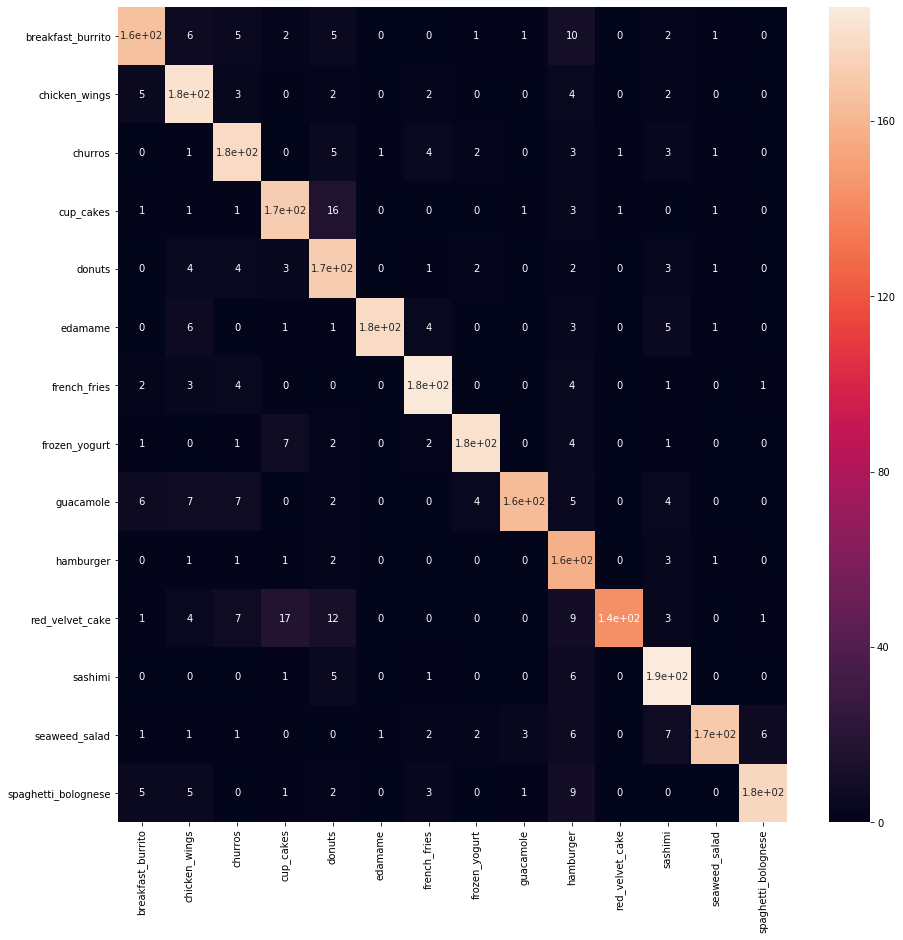

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cff, index = [i for i in listdir],
                  columns = [i for i in listdir])
plt.figure(figsize = (15,15))
sn.heatmap(df_cm, annot=True)